<div>
<h1>Run the cell below to generate the road map (do not modify it)</h1></div>

In [1]:
%%javascript
var kernel = IPython.notebook.kernel;var thename = window.document.getElementById("notebook_name").innerHTML;var command = "THE_NOTEBOOK = " + "'"+thename+"'";kernel.execute(command);command="os.environ['THE_NOTEBOOK'] = THE_NOTEBOOK";kernel.execute(command);var cell = IPython.notebook.get_cell(2);cell.execute();IPython.notebook.get_cell(3).focus_cell();var x = $('.code_cell');$(x[1]).children('.input').hide();

<IPython.core.display.Javascript object>

In [2]:
outputdir = "/tmp/tools/"
!mkdir -p $outputdir
!wget "https://www.dropbox.com/s/4g0pigmro4vo1b4/menutemplate?dl=0" -O /tmp/tools/menutemplate >> /tmp/toollog 2>&1 
!wget "https://www.dropbox.com/s/3flttpzhsja8td7/construct_menu.py?dl=0" -O /tmp/tools/construct_menu.py >> /tmp/toollog 2>&1 
!python /tmp/tools/construct_menu.py "{THE_NOTEBOOK}.ipynb" {outputdir}
from IPython.core.display import HTML
output_file_name = outputdir + THE_NOTEBOOK.replace(" ", "").replace("[", "").replace("]", "") + ".ipynb.html"
with open(output_file_name) as fp:
    html = fp.read()
HTML(html)

In this notebook, we will learn how to solve the regression problem of predicting flight delays, using decision trees and random forests.

# Goals
The main goals of this project are as follows:
1. Revisit the concepts behind Decision Trees and Random Forests
2. Build a simple methodology to address Data Science projects
3. Use the existing implementation of Random Forests in MLLib in a specific use case, that is to predict the delay of flights

# Steps

- First, in section 1, we will go through a short introduction about the fudamentals of Decision Trees and Random Forsests, such as feature definition, the form of a decision tree, how does it work and the idea of a forest of decision trees. If the student is familiar with these topics, skip to section 2.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data and the basic methodology to address the project in this notebook
- In section 3, we perform data exploration
- In section 4, we build the statistical model and validate it

# 1. Decision trees and Random Forests: Simple but Powerful Algorithms
> Prediction is very difficult, especially if it’s about the future. (Niels Bohr)
Decision trees are a very popular approach to prediction problems. Decision trees can be trained from both categorical and numerical features, to perform classification and regression. Classification and regression are the oldest and most well-studied types of predictive analytics. In many analytics packages and libraries, most algorithms are devoted either to address classification or regression problems, and they include for example support vector machines (SVM), neural networks, naïve Bayes, logistic regression, and deep learning...

In general, classification refers to the problem of predicting a label, or category, like *spam/not spam*, *rainy/sunny/mild*, for some given data. Regression refers to predicting a numeric quantity like salary, temperature, delay time, product's price. Both classification and regression involve predicting one (or more) values given one (or more) other input values. They require labelled data to perform a training phase, which builds the statistical model: they belong to *supervised learning* techniques.

## 1.1 Feature definition
To understand how regression and classification operate, it is necessary to briefly define the terms that describe their input and output. 

Assume that we want to predict the temperature of tomorrow given today's weather information.
The weather information is a loose concept. For example, we can use many variables to express today's weather such as:
* the average humidity today
* today’s high temperature
* today’s low temperature 
* wind speed
* outlook: e.g. cloudy, rainy, or clear
* ....

These variables are called *features* or *demensions*. 

Each variable can be quantified. For example, high and low temperatures are measured in degrees Celsius, humidity can be measured as a fraction between 0 and 1, and weather type can be labeled `cloudy`, `rainy` or `clear`...
So, the weather today can be expressed by a list of values: `11.4, 18.0, 0.64, 20, cloudy`
Each feature is also called a `predictor`. Together, they constitute a `feature vector`.

A feature whose domain is a set of categories is called **categorical feature**. In our example, `outlook` is a  categorical feature. A feature whose values are numerical is called **numerical feature**. In our example, `temperature` is a numerical feature.

Finally, tomorrow's temperature, that is what we want to predict, is called *target feature*.

## 1.2 Decision Trees & Random Forests
The first question that you might ask is: "Why Decision trees and not another approach?"

Well, the literature shows that the family of algorithms known as decision trees can naturally handle both categorical and numeric features. The training process is easy to understand. The model is easy to interpret. They are robust to outliers in the data, meaning that a few extreme and possibly erroneous data points should not affect the tree at all. The model can be trained in parallel easily. The accuracy is comparable to other methods... In short, there are lots of advantages when using decision trees with respect to other methods! 

The way we use a tree model is very simple to understand. We can say that this process "mimics" the way humans take decisions. For example, to decide whether to play football or not, a natural questions would be "does it rain now ?". If yes, the decision is `no`. If it's sunny, the condition is favorable to play football. A second natural question could be: "is it windy?". If no, then you may want to stay at home because otherwise it is going to be too hot. Otherwise, a third plausible question could be: "do we have enough people?". If no, then there's no point playing. Otherwise, time to play!

Using a decision tree allows to follow a similar process to that described above (see the image below). Given a new input, the algorithm traverses the tree in a such a way that the input satisfies the condition of each node until reaching a leaf one. The value of the leaf node is the decision.

![A decision tree](https://farm2.staticflickr.com/1690/24308350756_8533286fb5_z.jpg)

The tree model in the figure is built from historical information concerning many past days. The `feature predictor` contains three features: Rain, Is_Windy, Enough_People.
An example of the training data is as follows:

Rain | Is_Windy | Enough_People | Play
-----|----------|---------------|------
Yes | Yes | No | No
No  | No | No | No
No | Yes | Yes | Yes
No | No | Yes | No

As you can see, in the training data, we know the values of predictors and we also know the corresponding answer: we have the ground truth.

One limitation of decision trees is that it's easy to incur in overfitting problems. In other words, the model is too fit to the training data, it is too precise and not general enough. So, when testing the quality of predictions with different testing sets, accuracy could fluctuate. To overcome this limitation, the tree can be pruned after it is built, or even be pruned during the training process. Another approach is building a `Random Decision Forest`.

A `Random Decision Forest`, as its name implies, is a forest of random Decision trees. Each tree element is built randomly from the training data. Randomization generally applies to:
* Building new training data: Random selectiion of samples from the training data (with replacement) from the original training data
* When building a node: Random selection of a subset of features

To take a decision, the forest "asks" all trees about their prediction, and then chooses the outcome which is the most voted.

# 2. Usecase : Flights delay prediction
## 2.1 Context
Every day, in US, there are thousands of flights departures and arrivals: unfortunately, as you may have noticed yourself, flight delays are not a rare event!! Now, given historical data about flights in the country, including the delay information that was computed *a-posteriori* (so the ground truth is available), we want to build a model that can be used to predict how many minutes of delay a flight might experience in the future. This model should provide useful information for the airport to manage better its resources, to minimize the delays and their impact on the jurney of its passengers. Alternatively, astute passengers could even use the model to choose the best time for flying, such as to avoid delays.

## 2.2 Data
The data we will use in this notebook has been collected by the RITA (Research and Inovative Technology Administration), and it contains details facets about each air flight that happened in the US between 1987 and 2008. It includes 29 variables such as the origin airport, the destination airport, the scheduled departured time, day, month, the arrival delay... For more information, please visit the following [link](http://stat-computing.org/dataexpo/2009/the-data.html), that provides a lot of detail on the data. Our goal is to build a model to predict `the arrival delay`.

## 2.3 Methodology
For our project, we can follow a simple methodology:

- Understand clearly the context, the data and the goal of the project
- Pre-process the data (data cleaning): the data can contain invalid values or missing values. We have to process our data to deal with them
- Retrieve descriptive information about data: the idea is to discover if whether the data has patterns, whether features have patterns, the skew of values...
- Select appropriate features: Only work with significant features will save us memory, communication cost, and ultimately, training time. Feature selection is also important as it can reduce the impact of noise that characterize the unimportant features.
- Divide the data into training and testing set
- Build a model from the feature in the training set
- Test the model

# 3. Let's play: Data Exploration
Now it's time to apply the simple methodology outlined in section 2.3 on the usecase of this notebook.

**Note:** The source code in this lecture should be executed sequentially in the order.

## 3.1 Understanding the data schema

The data has 29 features, that can be either categorical or numerical. For example, the `src_airport` (source airport) is categorical: there exist no comparision operator between airport names. We can not say "SGN is bigger than NCE". The departure is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this usecase, most features are numerical, except `carier`, `flight_number`, `cancelled`, `cancelation_code` and `diverted`. 

The data contains a header, that is useless in building the statistical model. In addition, we already know the data schema, so we can safely neglect it. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction
- Using the DataFrame abstraction. DataFrames can be thought of as distributed tables: each item is a list of values  (the columns). Also, the value in each row of each column can be accesed by the column's name.

Next, we will focus on using DataFrames. However, to use DataFrames, the data must be clean (no invalid values). That means we can not create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an RDD[String]. We need to transform it to RDD[(TypeOfColumn1, TypeOfColumn2,.., TypeOfColumn29)] then call a function to create a DataFrame from the new RDD.


## 3.2 Data cleaning
Let's prepare for the cleaning step: Loading the data into an RDD.

First, we need to import some useful python modules for this notebook.

In [3]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches

# to start testing, we can focus on a single year
input_path = "/datasets/airline/1994.csv"
raw_data = sc.textFile(input_path)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 1 
Remove the header and replace the invalid values in our input dataset.

#### Question 1.1
How many records (rows) in the RAW data ?

In [4]:
print("number of rows before cleaning:", raw_data.count())

number of rows before cleaning: 5180049


<div class='anchor' ></div>
#### Question 1.2
Except for the first column, the others might contain missing values, which are denoted by `NA`. Remove the header and replace NA by an empty character. How many records are left after cleaning the RAW dataset?

NOTE: be careful with the valid values that can contain string `NA` inside.



In [5]:
# extract the header
header = raw_data.first();

# replace invalid data with NULL and remove header
cleaned_data = (
        raw_data
        # filter out the header
        .filter(lambda row : row != header)
        # replace the missing values with empty characters
        .map(lambda l : l.replace(',NA', ','))
    )

print("number of rows after cleaning:", cleaned_data.count())

number of rows after cleaning: 5180048


## 3.3 Transforming our data to a DataFrame

Now the data is clean, valid and can be used to create DataFrame. First, we will declare the data schema for the DataFrame. By doing that, we can specify the name and data type of each column.

In [6]:
sqlContext = SQLContext(sc)


# Declare the data schema
# see http://stat-computing.org/dataexpo/2009/the-data.html
# for more information
airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

To "convert" an RDD to DataFrame, each element in the RDD must be a list of column values that match the data schema.

In [7]:
# convert each line into a tuple of features (columns)
cleaned_data_to_columns = cleaned_data.map(lambda l: l.split(","))\
    .map(lambda cols:
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))

To train our model, we use the following features: `year`, `month`, `day_of_month`, `day_of_week`, `scheduled_departure_time`, `scheduled_arrival_time`, `arrival_delay`, `distance`, `src_airport`, `dest_airport`.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 2

From RDD `cleaned_data_to_columns` and the schema `airline_data_schema` which are declared before, create a new DataFrame **`df`**.

Note that, we should only select the necessary features defined above: [ year, month, day_of_month, day_of_week, scheduled_departure_time, scheduled_arrival_time, arrival_delay, distance, src_airport, dest_airport]. 

Finally, the data should be cached.

In [8]:
# create dataframe df
df = (sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)
      .select(['year', 'month', 'day_of_month', 'day_of_week',
               'scheduled_departure_time','scheduled_arrival_time',
               'arrival_delay', 'distance', 
               'src_airport', 'dest_airport', 'carrier'])
      .cache()
    )

## 3.4 Descriptive statistics
Next, we will go over a series of simple queries on our data, to explore it and compute statistics. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports ?
  - How many unique destination airports ?
  - How many carriers ?
  - How many flights that have a scheduled departure time later than 18h00 ?
  
- Statistic on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year ?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days ?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic) ?
  - Which are the top 20 busiest carriers ?
  
- Statistic on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day ?
  - Which hours of the day are characterized by the longest flight delay ?
  - What are the fluctuation of the percentage of delayed flights over different time granularities ?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports ?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers ?

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 3: Basic queries

#### Question 3.1 
How many origin airports ? How many destination airports ?

In [9]:
num_src_airport = df.select('src_airport').distinct().count()
num_dest_airport = df.select('dest_airport').distinct().count()
print("number of origin airports ", num_src_airport)
print("number of destination airports ", num_src_airport)

number of origin airports  224
number of destination airports  224


<div class='anchor' ></div>
#### Question 3.2
How many carriers ?

In [10]:
num_carrier = df.select('carrier').distinct().count()
print("the number distinct carriers:", num_carrier)

the number distinct carriers: 10


<div class='anchor' ></div>
#### Question 3.3
How many night flights (that is, flights departing later than 6pm) ?

In [11]:
print("the number of night flights:", df[df.scheduled_departure_time > 1800].count())

the number of night flights: 1078203


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 4: Flight volume statistics

#### Question 4.1: 
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.

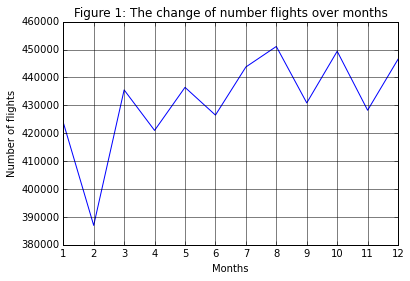

In [12]:
statistic_month = df.groupBy('month').count().collect()
#statistic_day_of_week.show()
pdf = pd.DataFrame(data=statistic_month)
plt.xlabel("Months")
plt.ylabel("Number of flights")
plt.title('Figure 1: The change of number flights over months')
plt.grid(True,which="both",ls="-")
plt.plot(pdf[0], pdf[1])
plt.xticks(range(1,13), pdf[0])
plt.xlim([1,12])
plt.show()

<div class="comment">
We can see from the plot that the flight traffic is significantly greater in certain months (e.g. August, October and December) while much lower in other months (such as February). However, this plot does not tell us about the traffic in terms of density (number of flights per day for each month), but rather the total amount of flights per month. We can tell this by seeing the pattern of longer months having more flights.
If we want to know the actual density we should make another plot.
</div>

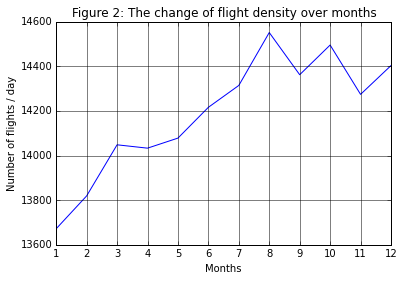

In [13]:
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for month in range(12):
    pdf[1][month] = pdf[1][month]/days_per_month[month]

plt.xlabel("Months")
plt.ylabel("Number of flights / day")
plt.title('Figure 2: The change of flight density over months')
plt.grid(True,which="both",ls="-")
plt.plot(pdf[0], pdf[1])
plt.xticks(range(1,13), pdf[0])
plt.xlim([1,12])
plt.show()

<div class="comment">
The plot above gives a better picture of the actual flight traffic for each month for making assumptions about when delays will occur more often. It seems like the months in the second half of the year bear a higher flight density than the months in the first half.
<br><br>Overall we could assume a general tendency towards an increase in air traffic. To prove this, we would have to look deeper into the data...
</div>

<div class='anchor' ></div>
#### Question 4.2: 
Is there any relationship between the number of flights and the days of the week? Plot a bar chart and interpret the figure.
By answering this question we could learn about the importance of the weekend/weekday feature for our predictive task.

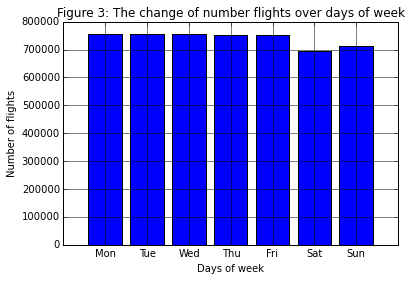

In [14]:
statistic_day_of_week = df.groupBy('day_of_week').count().collect()
#statistic_day_of_week.show()
pdf = pd.DataFrame(data=statistic_day_of_week)
plt.xlabel("Days of week")
plt.ylabel("Number of flights")
plt.title('Figure 3: The change of number flights over days of week')
plt.grid(True,which="both",ls="-")
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf[0].map(lambda i: map_int_into_day[i])

# plot bar chart
plt.bar(pdf[0], pdf[1], align='center')

plt.xticks(pdf[0], day_of_week_label)
plt.show()

<div class="comment">
We can observe a relationshep between the day of the week and the air traffic. On weekdays, the traffic is almost constantly high whereas it drops on weekends.
</div>

<div class='anchor' ></div>
#### Question 4.3
How many flights in different days of months and in different hours of days ? Plot  bar charts, and interpret your figures.

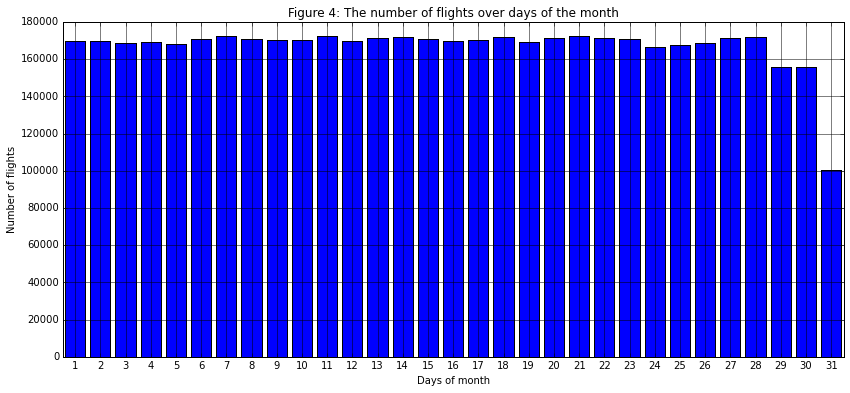

In [16]:

statistic_day_of_month = df.groupBy('day_of_month').count().collect()
#statistic_day_of_month.show()
pdf = pd.DataFrame(data=statistic_day_of_month)

plt.figure(num=None, figsize=(14,6))

# plot bar chart
plt.xlabel("Days of month")
plt.ylabel("Number of flights")
plt.title('Figure 4: The number of flights over days of the month')
plt.grid(True,which="both",ls="-")

# plot bar chart
plt.bar(pdf[0], pdf[1], align='center')
#plt.ylim([80000, 180000])
plt.xlim([0.5,31.5])
plt.xticks(range(1,32))
plt.show()

<div class="comment">
This figure shows us that there is not much difference in the number of flights per day of the month. However, the last days of the month are not always present in each month (i.e. 29th to 31th) which is why these days have lower flight counts. But this is just an artifact that comes from the way we collect data and doesn't give us any information about flight density on these days.
</div>

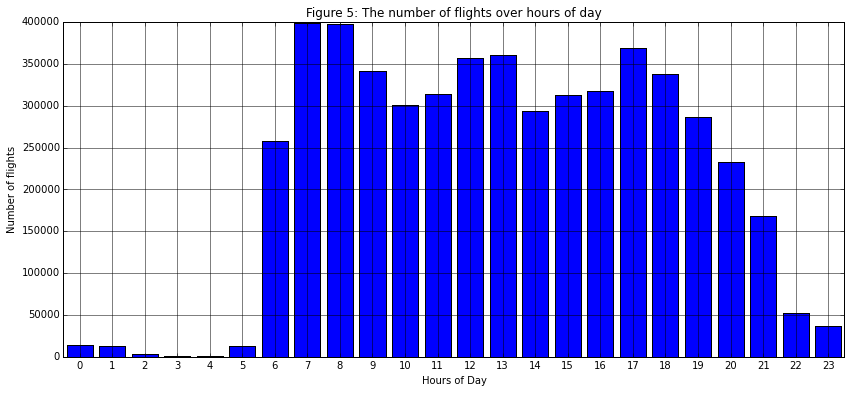

In [17]:
statistic_hour_of_day = df.select(floor(df.scheduled_departure_time / 100))\
                            .groupBy('FLOOR((scheduled_departure_time / 100))').count().collect()
    
#statistic_hour_of_day.show()
pdf = pd.DataFrame(data=statistic_hour_of_day)

plt.figure(figsize=(14,6))
# plot bar chart
plt.xlabel("Hours of Day")
plt.ylabel("Number of flights")
plt.title('Figure 5: The number of flights over hours of day')
plt.grid(True,which="both",ls="-")

# plot bar chart
plt.bar(pdf[0], pdf[1], align='center')
plt.xlim([-0.5,23.5])
plt.xticks(range(0,24))
plt.show()

<div class="comment">
We can observe a significant difference of the number of flights depending on the hour of day. At night (around 1-5 a.m.) there are nearly no flights, at morning (7-8 a.m.) we have the peak of flights and again at noon and in the evening (5 p.m.) we have local peaks.
</div>

<div class='anchor' ></div>
#### Question 4.4
Which are the top 20 busiest airports: compute this in terms of aggregate inbound and outbound number of flights ?

In [18]:
# consider outbound flights
stat_src = (df
            .groupBy(df.src_airport)
            .agg(func.count('*').alias('count1'))
            )
    
# consider inbound flights
stat_dest = (df
                .groupBy(df.dest_airport)
                .agg(func.count('*').alias('count2'))
            )


# full join the statistic of inbound flights and outbound flights
stat_airports = stat_src.join(stat_dest, stat_src.src_airport == stat_dest.dest_airport, how='outer')

# TOP 20 BUSIEST AIRPORTS
stat_airport_traffic = (stat_airports
                            # define the new column `total` 
                            # which has values are equal to the sum of `count1` and `count2`
                            .withColumn('total', stat_airports['count1'] + stat_airports['count2'])
                            # select top airpoint in termns of number of flights
                            .select(['src_airport', 'total']).orderBy(desc('total'))
                        )
stat_airport_traffic.show(20)

+-----------+------+
|src_airport| total|
+-----------+------+
|        ORD|561461|
|        DFW|516523|
|        ATL|443074|
|        LAX|306453|
|        STL|304409|
|        DEN|285526|
|        PHX|280560|
|        DTW|276272|
|        PIT|262939|
|        CLT|259712|
|        MSP|247980|
|        SFO|235478|
|        EWR|233991|
|        IAH|208591|
|        LGA|203362|
|        BOS|199696|
|        LAS|189920|
|        PHL|186897|
|        DCA|176115|
|        MCO|153720|
+-----------+------+
only showing top 20 rows



<div class='anchor' ></div>
#### Question 4.5
Which are the top 20 busiest carriers: compute this in terms of number of flights? 


In [19]:
stat_carrier = (df
                .groupBy('carrier')
                .agg(func.count('*').alias('count'))
                .orderBy(desc('count'))
                )

stat_carrier.show(20)

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 5 
Statistics on the percentage of delayed flights

#### Question 5.1
What is the percentage of delayed flights for different hours of the day? Plot a bar chart and interpret the figure.
Remember: a flight is considered as delayed if it's actual arrival time is more than 15 minutes late than the scheduled arrival time.

In [20]:
# create new column that marks whether the flights are delay
df_with_delay = df.withColumn('is_delay', when(df['arrival_delay'] >= 15, 1).otherwise(0))
df_with_delay = df_with_delay.withColumn('weighted_delay', \
                when(df_with_delay['is_delay'] ==1, df_with_delay['arrival_delay']).otherwise(0))

# create a new column that indicates the scheduled departure time in hour 
# (ignore the part of minute)
delay_per_hour = df_with_delay.withColumn('hour', round(df.scheduled_departure_time/100, 0))

# group by year and hour
statistic_delay_hour = delay_per_hour.groupBy(['year', 'hour'])

# calculate the delay ratio and create a new column
delay_ratio_per_hour = statistic_delay_hour.agg(
    (func.sum('is_delay')/func.count('*')).alias('delay_ratio')
)

    
# order the result by hour
delay_ratio_per_hour = (
            delay_ratio_per_hour
                .orderBy('hour')
                .select(['hour', 'delay_ratio'])
                .collect()
    )

pdf_delay_ratio_per_hour = pd.DataFrame(data=delay_ratio_per_hour)

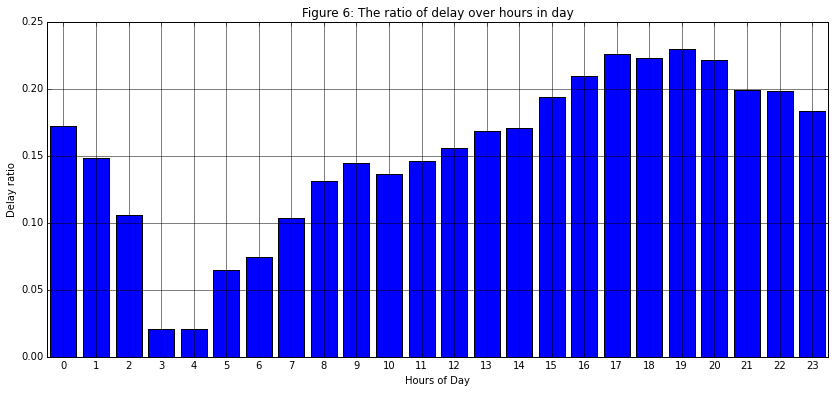

In [21]:
plt.figure(figsize=(14,6))
# plot bar chart
plt.xlabel("Hours of Day")
plt.ylabel("Delay ratio")
plt.title('Figure 6: The ratio of delay over hours in day')
plt.grid(True,which="both",ls="-")

plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center')
plt.xlim([-0.5,23.5])
plt.xticks(range(0,24))
plt.show()

<div class="comment">
We can see that the ratio of delays increases steadily from 5AM to 7PM, while decreasing over the night. This is probably because flight delays tend to propagate; that is, one delayed flight often leads to the next one being delayed as well, at least when there is a high density in air traffic. It seems that this delay will reset to some extent during the night, however it is not entirely clear from this figure as it only shows aggregates.
</div>

<div class='anchor' ></div>
#### Question 5.2

You will realize that saying "at 4 A.M. there is a very low chance of a flight being delayed" is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for a early flight to be delayed, but if it does, the delay might be huge, like 6 hours! 

Then, the question is: which hours of the day are characterized by the largest delay? Plot a Bar chart and explain it.

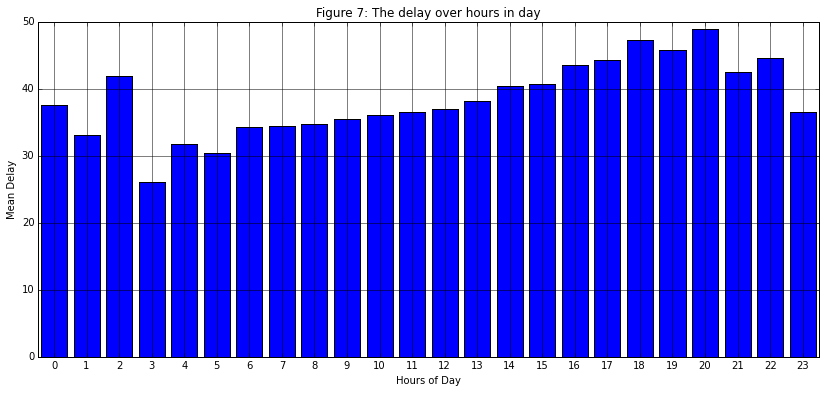

In [27]:
mean_delay_per_hour = statistic_delay_hour.agg(
    (func.sum('weighted_delay')/ func.sum('is_delay')).alias('mean_delay')
)
    
mean_delay_per_hour = (
    mean_delay_per_hour
        .orderBy('hour')
        .select(['hour','mean_delay'])
        .collect()
    )
    
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour)

plt.figure(figsize=(14,6))
# plot bar chart
plt.xlabel("Hours of Day")
plt.ylabel("Mean Delay")
plt.title('Figure 7: The delay over hours in day')
plt.grid(True,which="both",ls="-")

plt.bar(pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align='center')
plt.xlim([-0.5,23.5])
plt.xticks(range(0,24))
plt.show()

<div class="comment">
To create this figure we only considered delayed flights as the question was about the delay at any hour of the day, given there is delay. So this shows that the mean delay of an airplane (given it is delayed) does only depend slightly on the hour of the day. We see that the mean delay peaks around 6-8 p.m. and at 2 a.m..
<br><br>
However the values at night (1 a.m. - 4 a.m.) should be used carefully as they only consist of a few samples and can be biased by seldom events (few flights at that time of day and few of the delayed).
</div>

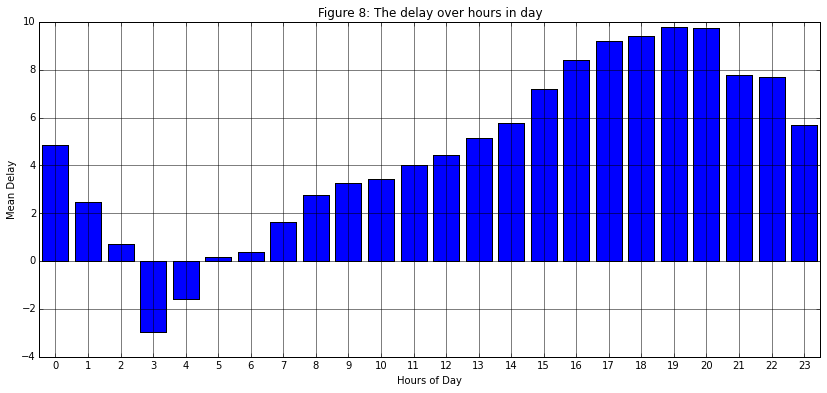

In [30]:
mean_delay_per_hour = statistic_delay_hour.agg(
    (func.mean('arrival_delay')).alias('mean_delay')
)
    
mean_delay_per_hour = (
    mean_delay_per_hour
        .orderBy('hour')
        .select(['hour','mean_delay'])
        .collect()
    )
    
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour)

plt.figure(figsize=(14,6))
# plot bar chart
plt.xlabel("Hours of Day")
plt.ylabel("Mean Delay")
plt.title('Figure 8: The delay over hours in day')
plt.grid(True,which="both",ls="-")

plt.bar(pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align='center')
plt.xlim([-0.5,23.5])
plt.xticks(range(0,24))
plt.show()

<div class="comment">
WRITE COMMENT HERE!
</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

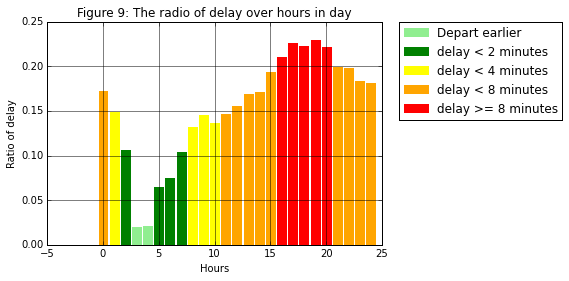

In [31]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 9: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart ealier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


<div class='anchor' ></div>
#### Question 5.3
Plot a bar chart to show the percentage of delayed flights over days in a month

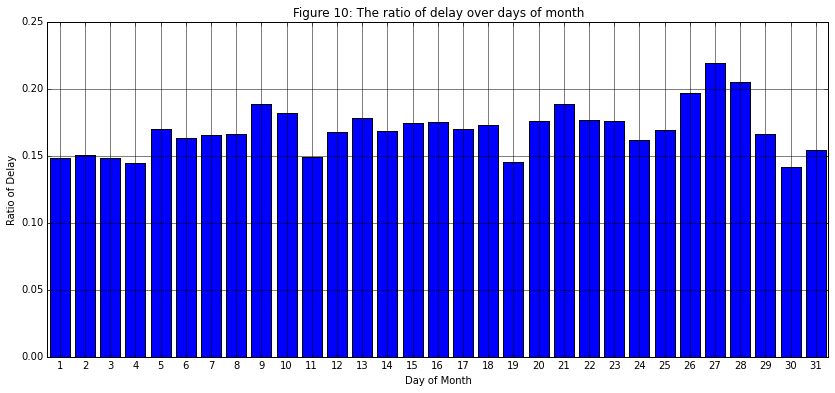

In [32]:
####### The changes of delay ratio over days of month ########
# calculate the delay ratio in each day of month
statistic_day_of_month = (
    df_with_delay
        .groupBy('day_of_month')
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        # order by day_of_month
        .orderBy('day_of_month')
    )

pdf_day_of_month = pd.DataFrame(data=statistic_day_of_month.collect())

# collect data and plot
plt.figure(figsize=(14,6))
plt.xlabel("Day of Month")
plt.ylabel("Ratio of Delay")
plt.title('Figure 10: The ratio of delay over days of month')
plt.grid(True,which="both",ls="-")

plt.bar(pdf_day_of_month[0], pdf_day_of_month[1], align='center')
plt.xlim([0.5,31.5])
plt.xticks(range(1,32))
plt.show()

<div class="comment">
We can see that the probability of a flight being delayed is very low at the beginning of the month (1.-4. day of month) and at the end of the month (29.-31. day of month). At the same time there is a high chance of delayed flights around the 26.-28. day of month.<br><br>
Again we need to be cautious about the last days of the month as there are less flights there in total so the probability of statistical outliers is higher there.
</div>

<div class='anchor' ></div>
#### Question 5.4
Plot a bar chart to show the percentage of delayed flights over days in a week

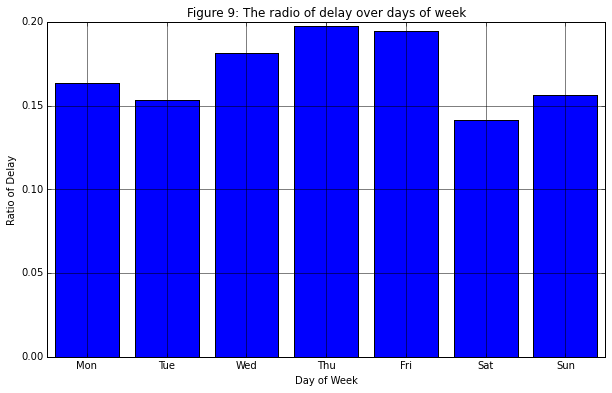

In [33]:
####### The changes of delay ratio over days of week ########
# calculate the delay ratio in each day of week
statistic_day_of_week = (
    df_with_delay
        .groupBy('day_of_week')
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        .orderBy('day_of_week')
    )
    
# collect data and plot
pdf_day_of_week = pd.DataFrame(data=statistic_day_of_week.collect())
map_int_into_day = { 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat", 7:"Sun" }
day_of_week_label = pdf_day_of_week[0].map(lambda i: map_int_into_day[i])

plt.figure(figsize=(10,6))
plt.xlabel("Day of Week")
plt.ylabel("Ratio of Delay")
plt.title('Figure 9: The radio of delay over days of week')
plt.grid(True,which="both",ls="-")

plt.bar(pdf_day_of_week[0], pdf_day_of_week[1], align='center')
plt.xlim([0.5,7.5])
plt.xticks(pdf_day_of_week[0], day_of_week_label)
plt.show()

<div class="comment">
The ratio of delay is highest during Thursday and Friday, and lowest on Saturdays. In general, it seems better to travel on the weekends, or on the beginning of the week (i.e. Saturday-Tuesday).
</div>

<div class='anchor' ></div>
#### Question 5.5
Plot a bar chart to show the percentage of delayed flights over months in a year

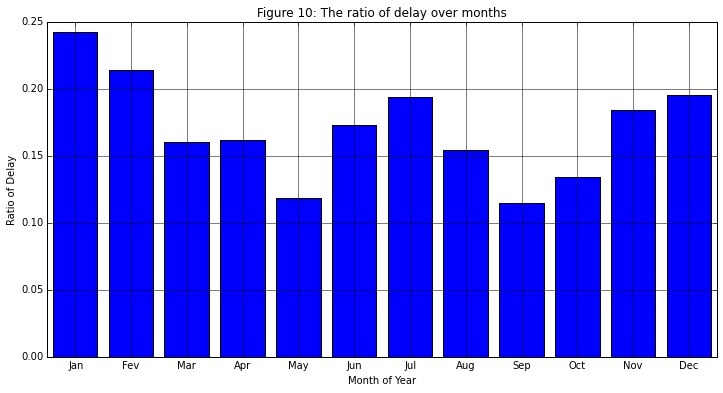

In [49]:
####### The changes of delay ratio over months ########
# calculate the delay ratio in month
statistic_month = (
    df_with_delay
    .groupby('month')
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
    # order by day_of_month
    .orderBy('month')
    )
    
# collect data and plot
pdf_month = pd.DataFrame(data=statistic_month.collect())

map_int_into_month = { 1:"Jan", 2:"Fev", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec" }
month_label = pdf_month[0].map(lambda i: map_int_into_month[i])

plt.figure(figsize=(12,6))
plt.xlabel("Month of Year")
plt.ylabel("Ratio of Delay")
plt.title('Figure 10: The ratio of delay over months')
plt.grid(True,which="both",ls="-")

plt.bar(pdf_month[0], pdf_month[1], align='center')
plt.xlim([0.5,12.5])
plt.xticks(pdf_month[0], month_label)
plt.show()

<div class="comment">
There seems to be an increase in delayed flights during the winter months (December to February) and during the summer high season (around July). The high ratio of delay in winter could be due to bad weather conditions, while the local peak in July could be due to vacations. The lowest ratio of delays are observed in May and September.
</div>

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [50]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

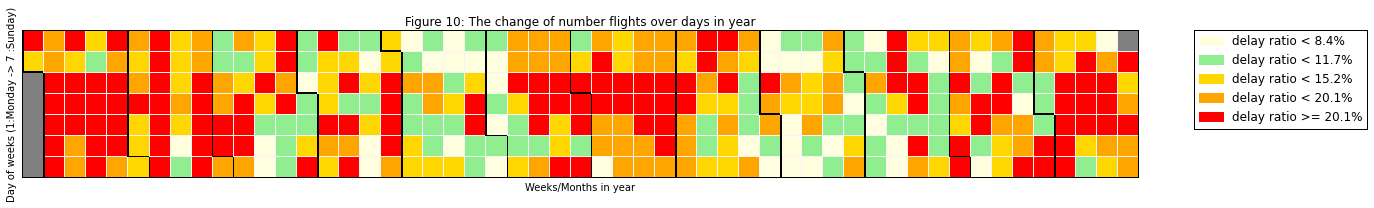

In [51]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

<div class='anchor' ></div>
#### Question 5.6
Explain figure 10.

<div class="answer">
Figure 10 summarizes all the observations we've already gathered in the previous figures. For example, we can see that January, February and July have a lot of delays, whereas May and September have far fewer. We can also observe that the middle of the week has more delays than the other days.
<br><br>
The only information that is hard to read from this figure is the ratio of delay over the days of the month.
</div>

<div class='anchor' ></div>
#### Question 5.7

What is the delay probability for the top 20 busiest airports?
By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relaltionship between aiports, number of flights and the delay.

HINT: Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.

In [34]:
####### The delay ratio of the top 20 busiest airports ########
K = 20

# extract top_20_airports from stat_airport_traffic
top_20_airports = [item[0] for item in stat_airport_traffic.take(K)]

# select the statistic of source airports
statistic_ratio_delay_airport = (
    df_with_delay
        # select only flights that depart from one of top 20 ariports
        .filter(df_with_delay['src_airport'].isin(top_20_airports))
        # group by source airport
        .groupBy('src_airport')
        #  calculate the delay ratio
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        # sort by name of airport
        .orderBy(['src_airport'])
    )
#statistic_ratio_delay_airport.show(20)

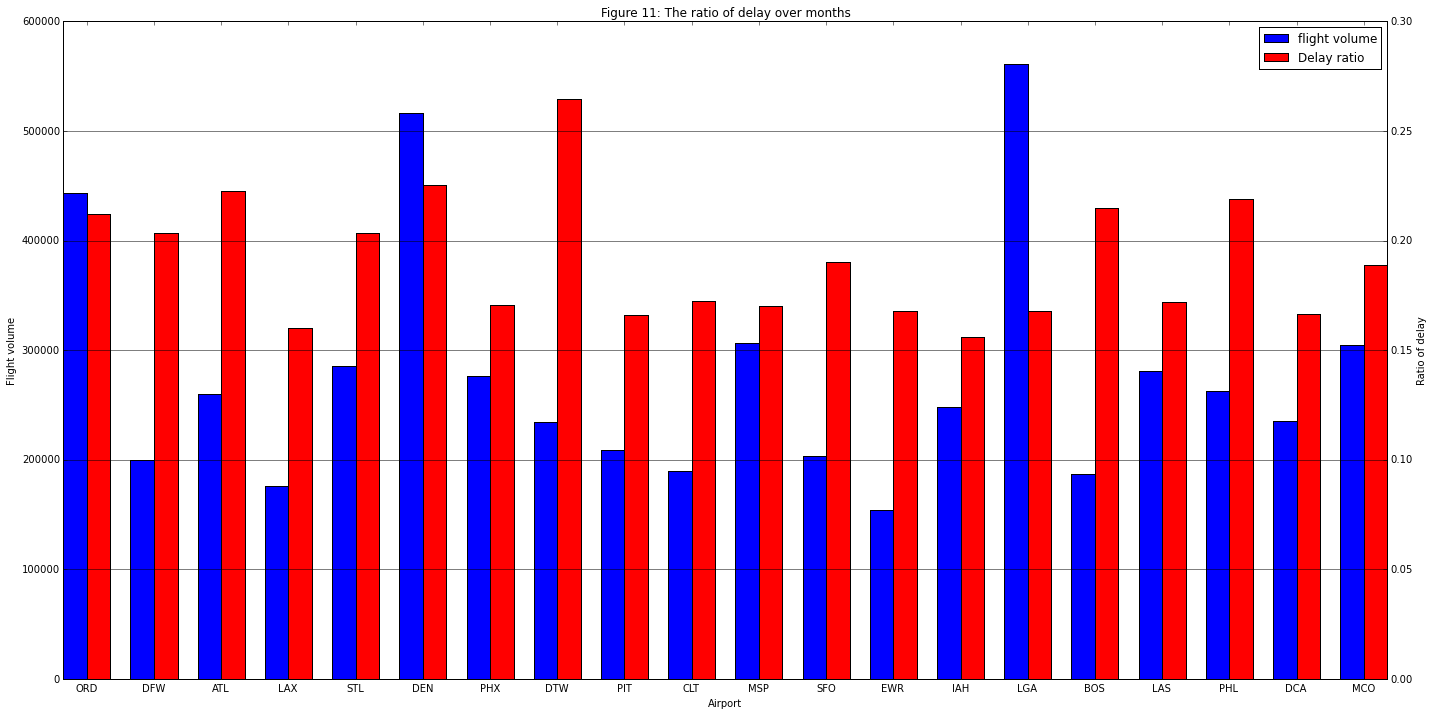

In [35]:
# collect data and plot
pdf_ratio_delay_airport = pd.DataFrame(data=statistic_ratio_delay_airport.collect())
pdf_top_20_airport_volume = pd.DataFrame(data=stat_airport_traffic.take(K), columns=['src_airport', 'total'])
pdf_top_20_airport_volume = pdf_top_20_airport_volume.sort_values(by='src_airport')
#print(pdf_top_20_airport_volume)
index = np.arange(len(top_20_airports))
bar_width = 0.35
opacity = 0.4


fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)

ax2 = ax.twinx()
plt.axis('normal')
ax.set_xlabel("Airport")
ax.set_ylabel("Flight volume")
ax2.set_ylabel("Ratio of delay")
plt.xticks(index + bar_width, top_20_airports)
plt.title('Figure 11: The ratio of delay over src airports')
plt.grid(True,which="both",ls="-")
bar = ax.bar(index, pdf_top_20_airport_volume['total'], 
        bar_width, color='b', 
        label='flight volume')
bar2 = ax2.bar(index + 1.5*bar_width, pdf_ratio_delay_airport[1], bar_width, 
       align='center', color='r', 
       label='Delay ratio')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()

<div class="comment">
This figure shows us that the flight volume and the delay ratio do not really correlate. Some airports like DEN have high flight volume and high delay ration, some have high flight volume and low delay ration like LGA, some have low flight volume and low delay ration like LAX and some have low flight volume and high delay ratio like DTW.
<br><br>
However we can observe some differences between the airports so knowing the source airport could help in predicting the delay.
</div>

<div class='anchor' ></div>
#### Question 5.8
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers? Comment the figure!

In [57]:
K = 20

# extract top_20_carriers from stat_carrier
top_20_carriers = [item[0] for item in stat_carrier.take(K)]

statistic_ratio_delay_carrier = (
    df_with_delay
        # select only flights that belong from one of top 20 carriers
        .filter(df_with_delay['carrier'].isin(top_20_carriers))
        # group by carriers
        .groupby('carrier')
        #  calculate the delay ratio
        .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
        # sort by name of carrier
        .orderBy(['carrier'])
    )
#statistic_ratio_delay_carrier.show(20)

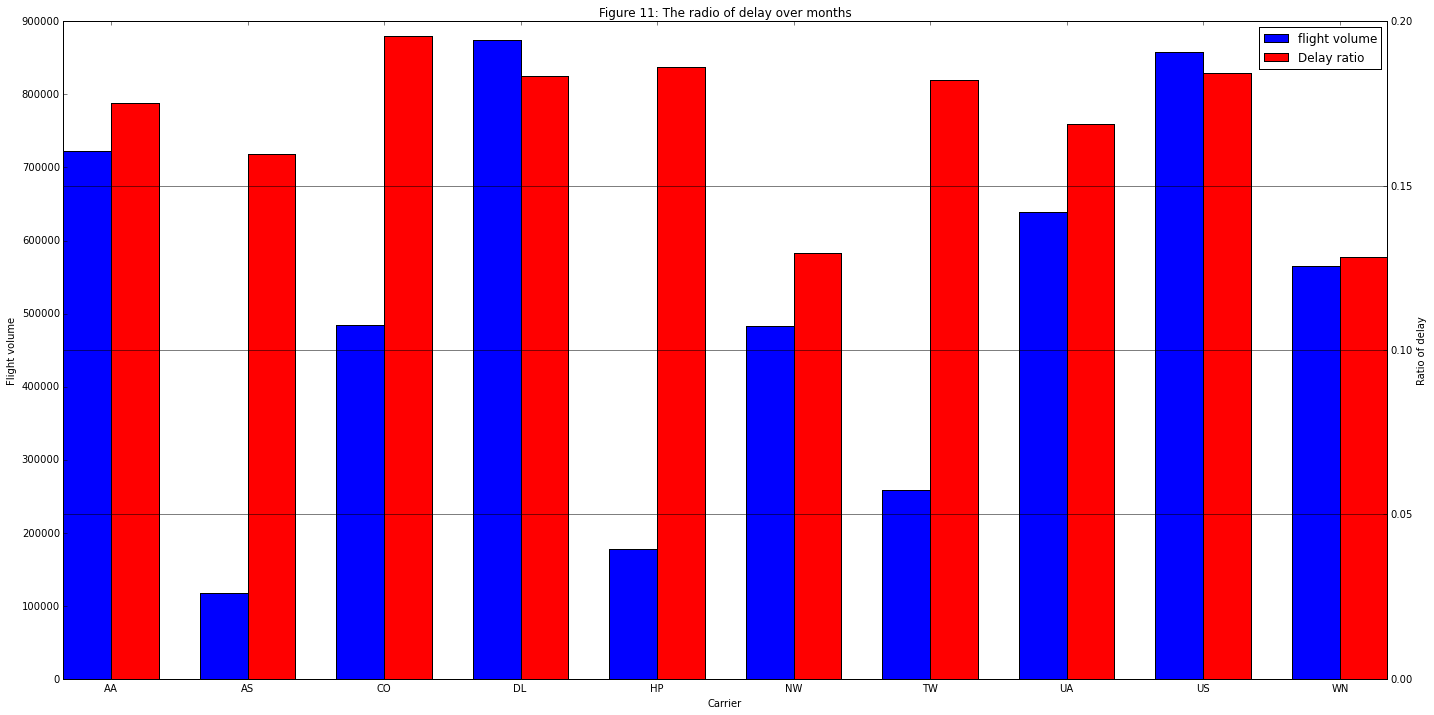

In [58]:
# collect data and plot
pdf_ratio_delay_carrier = pd.DataFrame(data=statistic_ratio_delay_carrier.collect())
pdf_top_20_carrier_volume = pd.DataFrame(data=stat_carrier.take(K), columns=['carrier', 'count'])
pdf_top_20_carrier_volume = pdf_top_20_carrier_volume.sort_values(by='carrier')
#print(pdf_top_20_carrier_volume)
top_20_carriers.sort()
index = np.arange(len(top_20_carriers))
bar_width = 0.35
opacity = 0.4


fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)

ax2 = ax.twinx()
plt.axis('normal')
ax.set_xlabel("Carrier")
ax.set_ylabel("Flight volume")
ax2.set_ylabel("Ratio of delay")
plt.xticks(index + bar_width, top_20_carriers)

plt.title('Figure 11: The radio of delay over months')
plt.grid(True,which="both",ls="-")
bar = ax.bar(index, pdf_top_20_carrier_volume['count'], 
        bar_width, color='b', 
        label='flight volume')
bar2 = ax2.bar(index + 1.5*bar_width, pdf_ratio_delay_carrier[1], bar_width, 
       align='center', color='r', 
       label='Delay ratio')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()

<div class="comment">
From this figure we can see that some carriers are more reliable than the others. It seems like flights of NW and WN are less likely to be dalyed while the other carriers have more or less the same ratio of delayed flights. The carrier with the highest ratio of delayed flights is CO. We cannot realy observe a correlation between the flight volume and the ratio of delayed flights.
</div>

# 4. Building a model of our data
Now that we have a good grasp on our data and its features, we will focus on how build a statistic model. Note that the features we can decide to use, to train our model, can be put in two groups:

- **Explicit features**: these are features that are present in the original data, or that can be built using additional data sources such as `weather` (for example querying a public API)
- **Implicit features**: these are the features that are inferred from other features such as `is_weekend`, `is_holiday`, `season`, `in_winter`,...

In this notebook, we will focus on the following predictors: `year`, `month`, `day_of_month`, `day_of_week`, `scheduled_departure_time`, `scheduled_arrival_time`, `carrier`, `is_weekend`, `distance`, `src_airport`, `dest_airport`. Among them, `is_weekend` is an implicit feature. The rest are explicit features.

The target feature is `arrival_delay`. 

Currently, MLLIB only supports building models from RDDs. It is important to read well the documentation and the MLLib API, to make sure to use the algorithms in an appropriate manner:

- MLLIB supports both categorical and numerical features. However, for each categorical feature, we have to indicate how many distinct values they can take
- Each training record must be a ```LabelledPoint```. This datastructure has 2 components: ```label``` and ```predictor vector```. ```label``` is the value of target feature in the current record. ```predictor vector``` is a vector of values of type ```Double```. As such, we need to map each value of each categorical feature to a number. In this project, we choose a naïve approach: map each value to an unique index. 
- MLLIB uses a binning technique to find the split point (the predicate in each tree node). In particular, it divides the domain of numerical features into ```maxBins``` bins (32 by default). With categorical features, each distinct value fits in its own bin. **IMPORTANT:** MLLIB requires that no categorical feature have more than `maxBins` distinct values.
- We fill up the missing values in each **categorical** feature with it's most common value. The missing values of a **numerical** feature are also replaced by the most common value (however, in some cases, a more sensible approach would be to use the median of this kind of feature).


## 4.1 Mapping values of each categorical feature to indices

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 6 

Among the selected features, `src_aiport`, `dest_airport`, `carrier` and `distance` have missing values. Besides, the first three of them are categorical features. That means, in order to use them as input features of MLLIB, the values of these features must be numberical. We can use a naïve approach: map each value of each feature to an unique index.

#### Question 6.1
Calculate the frequency of each source aiport in the data and build a dictionary that maps each of them to a unique index.

Note: we sort the airports by their frequency in descending order, so that we can easily take the most common airport(s) by taking the first element(s) in the result.

In [47]:
# select distinct source airports and map values to index
# sort the airport by their frequency descending
# so the most common aiport will be on the top
stat_src = (
    df
        .groupBy('src_airport')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    )

# extract the airport names from stat_src
src_airports = [item.src_airport for item in stat_src.collect()]

num_src_airports = len(src_airports)
src_airports_idx = range(0, num_src_airports)
map_src_airport_to_index = dict(zip(src_airports, src_airports_idx))

# test the dictionary
print(map_src_airport_to_index['ORD'])
print(map_src_airport_to_index['ATL'])
for key, value in map_src_airport_to_index.items():
    print(key, '\t', value)

0
2
PWM 	 96
SAT 	 40
AVP 	 138
GNV 	 162
MFR 	 163
HLN 	 179
BTV 	 124
ILM 	 149
KOA 	 192
MTJ 	 219
LFT 	 209
EVV 	 174
MOB 	 99
MLB 	 117
MCI 	 28
OME 	 184
MSP 	 10
JFK 	 36
CRW 	 142
FAT 	 126
PSG 	 198
GST 	 215
ADQ 	 203
ACK 	 218
MSO 	 153
OAK 	 35
SAN 	 26
BQN 	 195
RAP 	 172
BIL 	 114
HRL 	 97
LIT 	 66
GJT 	 210
SHV 	 104
SPI 	 223
ORD 	 0
MAF 	 88
GTF 	 146
MEM 	 31
PHF 	 158
AZO 	 136
ICT 	 86
SAV 	 90
OKC 	 58
OMA 	 69
DSM 	 81
LNK 	 132
LAN 	 144
MKE 	 65
BTR 	 100
BIS 	 164
MBS 	 113
SFO 	 11
IDA 	 175
VPS 	 178
ALB 	 77
PSE 	 217
BWI 	 22
DAB 	 105
BUF 	 57
FAY 	 139
AGS 	 122
IAD 	 49
RST 	 121
DTW 	 7
BTM 	 212
BET 	 188
PHL 	 17
LAX 	 3
CLE 	 25
HNL 	 75
SEA 	 20
GEG 	 84
ROC 	 64
ITH 	 177
DUT 	 205
MHT 	 108
ELP 	 51
DEN 	 5
GSO 	 46
TOL 	 143
LAS 	 16
STX 	 168
ANI 	 213
HPN 	 98
ABQ 	 45
GUC 	 211
PDX 	 43
AKN 	 204
LEX 	 103
PHX 	 6
JAN 	 102
BOI 	 94
HSV 	 87
TLH 	 93
MFE 	 120
IND 	 39
CVG 	 24
OAJ 	 182
LSE 	 173
IAH 	 13
HDN 	 201
SBA 	 151
PSC 	 170
MRY 	 1

## Comment
We see that the numbers associated to the airports are unique and the number of indexes corresponds to the number of airports we counted at the beginning of the notebook.

<div class='anchor' ></div>
#### Question 6.2
Calculate the frequency of each destination aiport in the data and build a dictionary that maps each of them to a unique index.

In [49]:
# select distinct destination airports and map values to index
# sort the airport by their frequency descending
# so the most common aiport will be on the top
stat_dest = (
    df
    .groupBy('dest_airport')
    .agg(func.count('*').alias('count'))
    .orderBy(desc('count'))
)

dest_airports = [item.dest_airport for item in stat_dest.collect()]

num_dest_airports = len(dest_airports)
dest_airports_idx = range(0, num_dest_airports)
map_dest_airports_to_index = dict(zip(dest_airports, dest_airports_idx))

# test the dictionary
print(map_dest_airports_to_index['ORD'])
print(map_dest_airports_to_index['ATL'])

for key, value in map_dest_airports_to_index.items():
    print(key, '\t', value)

0
2
PWM 	 96
SAT 	 42
AVP 	 138
GNV 	 161
MFR 	 163
HLN 	 178
BTV 	 125
ILM 	 149
KOA 	 191
MTJ 	 219
LFT 	 209
EVV 	 174
MOB 	 97
MLB 	 117
MCI 	 28
OME 	 185
MSP 	 10
JFK 	 37
CRW 	 144
BFI 	 224
FAT 	 126
PSG 	 198
GST 	 215
ADQ 	 203
ACK 	 218
MSO 	 153
OAK 	 35
SAN 	 26
BQN 	 195
RAP 	 172
BIL 	 113
HRL 	 98
LIT 	 66
GJT 	 210
SHV 	 104
SPI 	 223
ORD 	 0
MAF 	 88
GTF 	 147
MEM 	 31
PHF 	 157
AZO 	 136
ICT 	 86
SAV 	 90
OKC 	 58
OMA 	 70
DSM 	 81
LNK 	 132
LAN 	 145
MKE 	 65
BTR 	 100
BIS 	 165
MBS 	 115
SFO 	 11
IDA 	 175
VPS 	 179
ALB 	 77
PSE 	 217
BWI 	 22
DAB 	 105
BUF 	 57
FAY 	 140
AGS 	 122
IAD 	 49
RST 	 121
DTW 	 7
BTM 	 212
BET 	 188
PHL 	 17
LAX 	 3
CLE 	 25
HNL 	 75
SEA 	 20
GEG 	 84
ROC 	 64
ITH 	 177
DUT 	 205
MHT 	 108
ELP 	 51
DEN 	 5
GSO 	 45
TOL 	 143
LAS 	 16
STX 	 170
ANI 	 213
HPN 	 99
ABQ 	 46
GUC 	 211
PDX 	 43
AKN 	 204
LEX 	 103
PHX 	 6
JAN 	 101
BOI 	 95
HSV 	 87
TLH 	 93
MFE 	 120
IND 	 39
CVG 	 24
OAJ 	 183
LSE 	 173
IAH 	 13
HDN 	 201
SBA 	 151
PSC 	 1

<div class='anchor' ></div>
#### Question 6.3
Calculate the frequency of each carrier in the data and build a dictionary that maps each of them to a unique index.

In [46]:
# select distinct carriers and map values to index
# sort carriers by their frequency descending
# so the most common aiport will be on the top
stat_carrier = (
    df
    .groupBy('carrier')
    .agg(func.count('*').alias('count'))
    .orderBy(desc('count'))
)

carriers = [item.carrier for item in stat_carrier.collect()]

num_carriers = len(carriers)
carriers_idx = range(0, num_carriers)
map_carriers_to_index = dict(zip(carriers, carriers_idx))

for key, value in map_carriers_to_index.items():
    print(key,'\t', value)

UA 	 3
AS 	 9
DL 	 0
NW 	 6
WN 	 4
US 	 1
HP 	 8
TW 	 7
AA 	 2
CO 	 5


## 4.2 Calculating the most common value of each feature
We use a simple strategy for filling in the missing values : replacing them with the most common value of the corresponding feature.

**IMPORTANT NOTE:** features like ```month```, ```day_of_month```, etc... can be treated as numerical features in general. However, when it comes to build the model, it is much easier considering them as categorical features. In this case, to compute the most common value for such categorical features, we simply use the frequency of occurrence of each `label`, and chose the most frequent.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 7
In the previous question, when constructing the dictionary for categorical features, we also sort their statistical information in a such way that the most common value of each feature are placed on the top.

Note that, feature `is_weekend` has the most common value set to `0` (that is, `no` the day is not a weekend).

<div class='anchor' ></div>
#### Question 7.1
Find the most common value of feature `month` in data.



In [50]:
the_most_common_month = (
    df
        .groupBy('month')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

print("The most common month:", the_most_common_month)

The most common month: 8


<div class='anchor' ></div>
#### Question 7.2
Find the most common value of features `day_of_month` and `day_of_week`.

In [51]:
the_most_common_day_of_month = (
    df
        .groupBy('day_of_month')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_day_of_week = (
    df
        .groupBy('day_of_week')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

print("The most common day of month:", the_most_common_day_of_month)
print("The most common day of week:", the_most_common_day_of_week)

The most common day of month: 11
The most common day of week: 3


<div class='anchor' ></div>
#### Question 7.3
Find the most common value of features `scheduled_departure_time` and `scheduled_arrival_time`.

In [52]:
the_most_common_s_departure_time = (
    df
        .groupBy('scheduled_departure_time')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

the_most_common_s_arrival_time = (
    df
        .groupBy('scheduled_arrival_time')
        .agg(func.count('*').alias('count'))
        .orderBy(desc('count'))
    ).first()[0]

print("The most common scheduled departure time:", the_most_common_s_departure_time)
print("The most common scheduled arrival time:", the_most_common_s_arrival_time)

The most common scheduled departure time: 700
The most common scheduled arrival time: 1915


<div class='anchor' ></div>
#### Question 7.4
Calculate the mean of distance in the data. This value will be used to fill in the missing values of feature `distance` later.

In [53]:
# calculate mean distance
mean_distance = df.agg(func.mean('distance').alias('mean')).first()[0]
print("mean distance:", mean_distance)

mean distance: 670.7402911985982


<div class='anchor' ></div>
#### Question 7.5
Calculate the mean of arrival delay.

In [63]:
# calculate mean arrival delay
mean_arrival_delay = df.agg(func.mean('arrival_delay')).first()[0]
print("mean arrival delay:", mean_arrival_delay)

mean arrival delay: 5.662489742613603


As known from section 3.4, there are 225 different origin airports and 225 different destination airports, more than the number of bins in default configuration. So, we must set `maxBins` >= 225.

## 4.3 Preparing training data and testing data
Recall, in this project we focus on decision trees. One way to think about our task is that we want to predict the unknown `arrival_delay` as a function combining several features, that is:

`arrival_delay = f(year, month, day_of_month, day_of_week, scheduled_departure_time, scheduled_arrival_time, carrier, src_airport, dest_airport, distance, is_weekend)`

When categorical features contain corrupt data (e.g., missing values), we proceed by replacing corrupt information with the most common value for the feature. For numerical features, in general, we use the same approach as for categorical features; in some cases, we repair corrupt data using the mean value of the distribution for numerical features (e.g., we found the mean for `delay` and `distance`, by answering questions above).

The original data is split randomly into two parts with ratios 70% for **training** and 30% for **testing**.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 8
- Replace the missing values of each feature in our data by the corresponding most common value or mean.
- Divide data into two parts: 70% for training and 30% for testing

In [67]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint


def is_valid(value):
    return value != "NA" and len(value) > 0

data = cleaned_data\
    .map(lambda line: line.split(','))\
    .map(lambda values: 
        LabeledPoint( 
            int(values[14]) if is_valid(values[14]) else mean_arrival_delay, # arrival delay
            [
                int(values[0]), # year
                int(values[1]) if is_valid(values[1]) else most_common_month, # month
                int(values[2]) if is_valid(values[2]) else the_most_common_day_of_month, # day of month
                int(values[3]) if is_valid(values[3]) else the_most_common_day_of_week, # day of week
                int(values[5]) if is_valid(values[5]) else the_most_common_s_departure_time, # scheduled departure time
                int(values[7]) if is_valid(values[7]) else the_most_common_s_arrival_time, # scheduled arrival time
                # if the value is valid, map it to the corresponding index
                # otherwise, use the most common value
                map_carriers_to_index[values[8]] if is_valid(values[8]) \
                    else map_carriers_to_index[carriers[0]], # carrier
                map_src_airport_to_index[values[16]] if is_valid(values[16]) \
                    else map_src_airport_to_index[src_airports[0]], # src_airport
                map_dest_airports_to_index[values[17]] if is_valid(values[17]) \
                    else map_dest_airports_to_index[dest_airports[0]], # destination_airport
                int(values[18]) if is_valid(values[18]) else mean_distance, # distance
                1 if is_valid(values[3]) and int(values[3]) >= 6 else 0, # is_weekend
            ]
        )
    )

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

## 5.4 Building a decision tree model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 9
We can train a decision model by using function `DecisionTree.trainRegressor(<training_data>, categoricalFeaturesInfo=<categorical_info>, impurity=<impurity_function>,  maxDepth=<max_depth>, maxBins=<max_bins>)`.

Where,

* `training_data` : the data used for training
* `categorical_info` : a dictionary that maps the index of each categorical features to its number of distince values
* `impurity_function` : the function that is used to calculate impurity of data in order to select the best split
* `max_depth`: the maximum depth of the tree
* `max_bins`: the maximum number of bins that the algorithm will divide on each feature. Note that, `max_bins` can not smaller than the number distinct values of every categorical features.

Complete the code below to train a decision tree model.


In [68]:
# declare information of categorical features
# format:  feature_index : number_distinct_values
categorical_info = {6 : num_carriers, 7: num_src_airports, 8: num_dest_airports, 10: 2}

# Train a DecisionTree model.
model = DecisionTree.trainRegressor(trainingData, 
                                    categoricalFeaturesInfo=categorical_info,
                                    impurity='variance', maxDepth=12, maxBins=255)

## 5.5 Testing the decision tree model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 10
#### Question 10.1
We often use Mean Square Error as a metric to evaluate the quality of a tree model. Complete the code below to calculate the MSE of our trained model.

In [77]:
# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)

testMSE = labelsAndPredictions.map(
    lambda p: np.square(p[0] - p[1])).mean()

print('Test Mean Squared Error = ' + str(testMSE))

Test Mean Squared Error = 491.781606893


In [79]:
print(labelsAndPredictions.take(20))

[(88.0, 1.8290629811557968), (21.0, 1.8290629811557968), (-8.0, 1.8290629811557968), (-16.0, 1.8290629811557968), (5.662489742613603, 1.8290629811557968), (-2.0, -2.7159073483897447), (3.0, 1.8290629811557968), (17.0, 1.8290629811557968), (2.0, -3.364173105716769), (-1.0, 1.8290629811557968), (3.0, 1.8290629811557968), (-13.0, -3.364173105716769), (-14.0, -3.364173105716769), (-5.0, 1.8290629811557968), (-15.0, 1.8290629811557968), (-11.0, 1.8290629811557968), (-9.0, 1.8290629811557968), (-9.0, 1.8290629811557968), (13.0, 20.130969663105205), (2.0, 20.130969663105205)]


<div class='anchor' ></div>
### Question 10.2
Comment the results you have obtained. Is the MSE value you get from a decision tree indicating that our statistical model is very good in predicting airplane delays? Use your own words to describe and interpret the value you obtained for the MSE.

<div class="answer">
This is a very bad result. The mean squared error was roughly 492 which is really not good. We do not have a value to compare our result with, but either we have some really strange outliers or our predictions are generally not very precise. To be better able to evaluate our decision tree we generate a histogram of prediction errors:
</div>

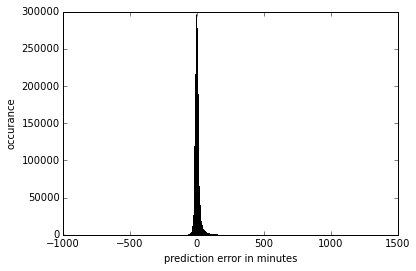

In [90]:
predictionerrors = labelsAndPredictions.map(lambda p: p[0] - p[1])
minerror = predictionerrors.min()
maxerror = predictionerrors.max()

#histogram = np.histogram(predictionerrors, bins= np.arange(minerror, maxerror, 5))

plt.hist(predictionerrors.collect(), bins= np.arange(minerror, maxerror, 5))
plt.xlabel('prediction error in minutes')
plt.ylabel('occurance')
plt.show()

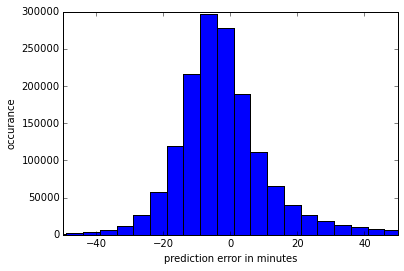

In [91]:
plt.hist(predictionerrors.collect(), bins= np.arange(minerror, maxerror, 5))
plt.xlabel('prediction error in minutes')
plt.ylabel('occurance')
plt.xlim(-50,50)
plt.show()

## 5.6 Building random decision forest model (or random forest)
Next, we use MLLib to build a more powerful model: random forests. In what follows, use the same predictors defined and computed above to build a decision tree, but this time use them to build a random decision forest.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>
### Question 11
Train a random decision forest model and evaluate its quality using MSE metric. Compare to decision tree model and comment the results. Similarly to question 10.2, comment with your own words the MSE value you have obtained.

In [100]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=12, maxBins=255)


# Evaluate model on test instances and compute test error
forest_predictions = forest_model.predict(testData.map(lambda x: x.features))
forest_labelsAndPredictions = testData.map(lambda lp: lp.label).zip(forest_predictions)

forest_testMSE = forest_labelsAndPredictions.map(
    lambda p: np.square(p[0] - p[1])).mean()

print('Test Mean Squared Error = ' + str(forest_testMSE))

Test Mean Squared Error = 487.239291272


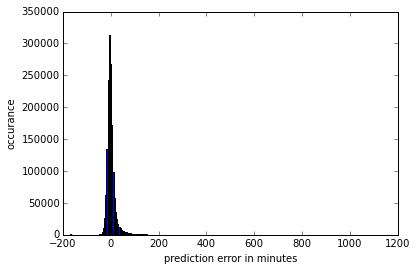

In [88]:
predictionerrors = forest_labelsAndPredictions.map(lambda p: p[0] - p[1])
minerror = predictionerrors.min()
maxerror = predictionerrors.max()

#histogram = np.histogram(predictionerrors, bins= np.arange(minerror, maxerror, 5))

plt.hist(predictionerrors.collect(), bins= np.arange(minerror, maxerror, 5))
plt.xlabel('prediction error in minutes')
plt.ylabel('occurance')
plt.show()

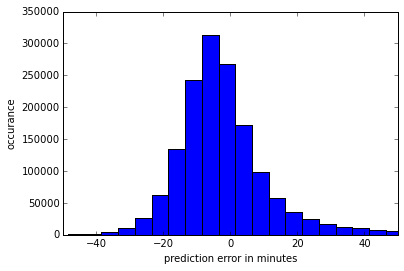

In [89]:
plt.hist(predictionerrors.collect(), bins= np.arange(minerror, maxerror, 5))
plt.xlabel('prediction error in minutes')
plt.ylabel('occurance')
plt.xlim(-50,50)
plt.show()

<div class="comment">
In this case, we already have something to compare our model with (the previous prediction). We can see that our testMSE value was very similar, although a little bit better. From our histogram plots, we can see that the predictions might be less optimistic than in the previous one. In the random forest we have more (or heavier) outliers with "high positive" prediction errors, while in the decision tree we have more (or heavier) outliers with "high negative" prediction errors. 
</div>

## 5.7 Parameter tuning
In this lecture, we used `maxDepth=12`, `maxBins=255`, `numTrees=10`. Next, we are going to explore the meta-paramter space a little bit.

For more information about parameter tunning, please read the documentation of [MLLIB](http://spark.apache.org/docs/latest/mllib-decision-tree.html#tunable-parameters)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

### Question 12
Train the random forest model using different parameters, to understand their impact on the main performance metric we have used here, that is the MSE. For example, you can try a similar approach to that presented in the Notebook on reccommender systems, that is using nested for loops.

**NOTE:** be careful when selecting parameters as some might imply very long training times, or eventually, the typical memory problems that affect Spark!

In [113]:
maxDepthValues = [10,14]
maxBinsValues = [255, 300]
numTreesValues = [8,12]


for depth in maxDepthValues:
    for bins in maxBinsValues:
        for trees in numTreesValues:
            forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=trees, impurity='variance', maxDepth=depth, maxBins=bins)
            
            # Evaluate model on test instances and compute test error
            forest_predictions = forest_model.predict(testData.map(lambda x: x.features))
            forest_labelsAndPredictions = testData.map(lambda lp: lp.label).zip(forest_predictions)

            testMSE = forest_labelsAndPredictions.map(lambda p: np.square(p[0] - p[1])).mean()

            print('Given depth=%d maxBins=%d numTrees=%d, MSE = %f' % (depth, bins, trees, testMSE))

Given depth=10 maxBins=255 numTrees=8, MSE = 502.579234
Given depth=10 maxBins=255 numTrees=12, MSE = 502.861170
Given depth=10 maxBins=300 numTrees=8, MSE = 503.928697
Given depth=10 maxBins=300 numTrees=12, MSE = 502.542523
Given depth=14 maxBins=255 numTrees=8, MSE = 474.939173
Given depth=14 maxBins=255 numTrees=12, MSE = 472.997683
Given depth=14 maxBins=300 numTrees=8, MSE = 478.765562
Given depth=14 maxBins=300 numTrees=12, MSE = 474.289616


<div class="comment">
We reduced the number of possible values for each feature to two values (mostly around the used one) to reduce the computation time.
<br>
However it seems that the best value we could reach, was with the setting: depth = 14, maxBins=255, numTrees=12.
</div>

# 6. Addition (bonus) questions
As you may have noticed, the performance of our statistical models is somehow questionable! What are we missing here? Why is that even using state-of-the-art approaches give poor results?

In what follows, we will try to address some of the limitations of the present Notebook, and provide additional data that might help.

## 6.1. Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994), which could be used to train a statistical model with more data. In the end, we're playing with "Big Data", hence one might think that feeding more training data to the algorithm should help!

## 6.2. Feature selection

You might think that the flight delays do not only depend on the source aiport, destination airport, departure time, etc... as we assumed. They also depend on other features such as the weather, the origin country, the destination city,... To improve the prediction quality, we should consider these features too.

There are some other datasets that related to this usecase:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers API and obtain (at a limited rate) hystorical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

<div class='anchor' ></div>

### Question 13
Using the data sources above, select additional feature and repeat the process of defining an appropriate training and test datasets, to evaluate the impact of new features on the performance of the model. Focus first on decision trees, then move to random forests.

In [114]:
# First of all we try to use the whole data
raw_input_path = "/datasets/airline/"
raw_data = sc.textFile("/datasets/airline/*.csv")

In [115]:
# extract the header
header = raw_data.first();

# replace invalid data with NULL and remove header
cleaned_data = (
        raw_data
        # filter out the header
        .filter(lambda row : row != header)
        # replace the missing values with empty characters
        .map(lambda l : l.replace(',NA', ','))
    )

In [117]:
raw_plane_data = sc.textFile('plane-data.csv')

In [118]:
# extract the header
header = raw_plane_data.first();

# replace invalid data with NULL and remove header
cleaned_plane_data = (
        raw_plane_data
        # filter out the header
        .filter(lambda row : row != header)
        # replace the missing values with empty characters
        .map(lambda l : l.replace(',NA', ','))
    )

In [119]:

# Declare the data schema
# see http://stat-computing.org/dataexpo/2009/the-data.html
# for more information
plane_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("tailnum",                  StringType(), True), \
    StructField("type",                     StringType(), True), \
    StructField("manufacturer",             StringType(), True), \
    StructField("issue_date",               StringType(), True), \
    StructField("model",                    StringType(), True), \
    StructField("status",                   StringType(), True), \
    StructField("aircraft_type",            StringType(), True), \
    StructField("engine_type",              StringType(), True), \
    StructField("year",                     IntegerType(),  True) \
])

# convert each line into a tuple of features (columns)
cleaned_plane_data_to_columns = cleaned_plane_data.map(lambda l: l.split(","))\
    .map(lambda cols:
         (
            cols[0]  if cols[0] else None,
            cols[1]  if cols[1] else None,
            cols[2]  if cols[2] else None,
            cols[3]  if cols[3] else None,
            cols[4]  if cols[4] else None,
            cols[5]  if cols[5] else None,
            cols[6]  if cols[6] else None,
            cols[7]  if cols[7] else None,
            int(cols[8]) if cols[8] else None
         ))

In [126]:
cleaned_plane_data.take(40)

['N050AA',
 'N051AA',
 'N052AA',
 'N054AA',
 'N055AA',
 'N056AA',
 'N057AA',
 'N058AA',
 'N059AA',
 'N060AA',
 'N061AA',
 'N062AA',
 'N063AA',
 'N064AA',
 'N065AA',
 'N066AA',
 'N067AA',
 'N068AA',
 'N069AA',
 'N070AA',
 'N071AA',
 'N072AA',
 'N073AA',
 'N074AA',
 'N075AA',
 'N076AA',
 'N077AA',
 'N078AA',
 'N079AA',
 'N080AA',
 'N081AA',
 'N082AA',
 'N083AA',
 'N084AA',
 'N10156,Corporation,EMBRAER,02/13/2004,EMB-145XR,Valid,Fixed Wing Multi-Engine,Turbo-Fan,2004',
 'N102UW,Corporation,AIRBUS INDUSTRIE,05/26/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998',
 'N10323,Corporation,BOEING,07/01/1997,737-3TO,Valid,Fixed Wing Multi-Engine,Turbo-Jet,1986',
 'N103US,Corporation,AIRBUS INDUSTRIE,06/18/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999',
 'N104UA,Corporation,BOEING,01/26/1998,747-422,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1998',
 'N104UW,Corporation,AIRBUS INDUSTRIE,07/02/1999,A320-214,Valid,Fixed Wing Multi-Engine,Turbo-Fan,1999']

In [120]:
plane_df = (sqlContext.createDataFrame(cleaned_plane_data_to_columns, plane_data_schema)
      .select(['tailnum', 'model', 'year'])
      .cache()
    )

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 791.0 failed 4 times, most recent failure: Lost task 0.3 in stage 791.0 (TID 15034, spark-worker0-aml-lab-group13-prod-zoe.group13-prod-zoe): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/pyspark/rdd.py", line 1295, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-119-2517b47a2964>", line 21, in <lambda>
IndexError: list index out of range

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:300)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1283)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1271)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1270)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1270)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:697)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:697)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1496)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1458)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1447)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1824)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:393)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor97.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 263, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/opt/spark/python/pyspark/rdd.py", line 1295, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-119-2517b47a2964>", line 21, in <lambda>
IndexError: list index out of range

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:300)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:264)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:88)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


In [121]:
plane_df.take(40)

NameError: name 'plane_df' is not defined

In [ ]:
data = cleaned_data\
    .map(lambda line: line.split(','))\
    .map(lambda values: 
        LabeledPoint( 
            int(values[14]) if is_valid(values[14]) else mean_arrival_delay, # arrival delay
            [
                int(values[0]), # year
                int(values[1]) if is_valid(values[1]) else most_common_month, # month
                int(values[2]) if is_valid(values[2]) else the_most_common_day_of_month, # day of month
                int(values[3]) if is_valid(values[3]) else the_most_common_day_of_week, # day of week
                int(values[5]) if is_valid(values[5]) else the_most_common_s_departure_time, # scheduled departure time
                int(values[7]) if is_valid(values[7]) else the_most_common_s_arrival_time, # scheduled arrival time
                # if the value is valid, map it to the corresponding index
                # otherwise, use the most common value
                map_carriers_to_index[values[8]] if is_valid(values[8]) \
                    else map_carriers_to_index[carriers[0]], # carrier
                map_src_airport_to_index[values[16]] if is_valid(values[16]) \
                    else map_src_airport_to_index[src_airports[0]], # src_airport
                map_dest_airports_to_index[values[17]] if is_valid(values[17]) \
                    else map_dest_airports_to_index[dest_airports[0]], # destination_airport
                int(values[18]) if is_valid(values[18]) else mean_distance, # distance
                1 if is_valid(values[3]) and int(values[3]) >= 6 else 0, # is_weekend
            ]
        )
    )

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

trainingData = trainingData.cache()
testData = testData.cache()

In [ ]:
# Train a RandomForest model.
forest_model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo=categorical_info,
                                    numTrees=10, impurity='variance', maxDepth=12, maxBins=255)


# Evaluate model on test instances and compute test error
forest_predictions = forest_model.predict(testData.map(lambda x: x.features))
forest_labelsAndPredictions = testData.map(lambda lp: lp.label).zip(forest_predictions)

forest_testMSE = forest_labelsAndPredictions.map(
    lambda p: np.square(p[0] - p[1])).mean()

print('Test Mean Squared Error = ' + str(forest_testMSE))

In [ ]:
! hdfs dfs -ls /datasets/airline

> The important thing is to not stop questioning. Curiosity has its own reason for existence. (Albert Einstein)

<div class="note">
Be active ! Ask yourself other questions which help you explore more about this data and try to answer them. Make this notebook be a part of your CV !
</div>

# Summary
In this lecture, we've had an overview about Decision Trees, Random Forests and how to use them. We also insisted on a simple methodology to adopt when dealing with a Data Science problem. 
The main take home messages should be:

* Feature selection is a difficult, delicate and important task. In this project, the student was heavily guided. However, we invite to exercise with additional features, for example external ones related to weather conditions.

* Parameter tuning requires a deep understanding of the algorithm used to build a statistical model. In general, to reduce computational cost, several techniques introduce parameters that, if tuned properly, can lead to tremendous time savings.